# Redes neuronales en pytorch

En esta lección ya utilizaremos pytorch para definir algunos modelos de ML y DL, además de ajustarlos y ver sus métricas. En este cuaderno veremos dos modelos:

* Regresión logística
* Perceptrón multicapa

### Regresión logística para el dataset MNIST

Empezamos creando un modelo no profundo (regresión logística), más todo el código de entrenamiento para entrenar y evaluar este modelo sobre el dataset MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Ahora, definiremos algunos hiperparámetros y opciones para el entrenamiento

In [2]:
# Fijamos la semilla aleatoria, con lo que el experimento es reproducible
seed = 0
torch.manual_seed(seed)
# Por el momento, entrenaremos en CPU
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
# Usamos un tamaño de batch de 32 ejemplos para entrenar. Lo dejamos en 1000 para evaluar.
batch_size = 32
test_batch_size = 1000
# Usaremos SGD con un término de momento
momentum = 0.5
# La tasa de aprendizaje
lr = 0.01
# El número de épocas
epochs = 3
# El tamaño del input. El MNIST consiste en imágenes en escala de grises, 28x28 pixeles
im_size = 28*28

Ahora, ya estamos listos para definir nuestro modelo de pytorch. Esto se hace creando una clase que extiende nn.Module, con dos métodos:

* __init__ : usado para definit e inicializar los parámetros del modelo. Para el caso de regresión logística, el único parámetro entrenable es una matriz de tamaño 28*28 x 10, porque queremos proyectar a un espacio de 10 dimensiones para predecir el dígito (0 - 9). Podriamos calcular esta multiplicación a mano, pero pytorch cuenta con nn.Linear que es un atajo para la proyección lineal

* forward: usado para definir la computación en el modelo. Simplemente aplicaremos la proyección lineal al input, y luego la transformación softmax (por lo que el output del modelo puede ser interpretado como una distribución de probabilidad sobre los 10 dígitos)




Notemos dos cosas:

1. Como las imágenes del MNIST son tensores de tamaño 28x28, y el operador Linear espera un array unidimensional (porque es la operación W x vector(imagen), tenemos que aplanar la imagen usando el método view (es como un reshape)

2. Como la función de coste es nll_loss (vemos la siguiente celda), espera que su input este en espacio logarítmico, por lo que usamos log_softmax en vez de softmax (ver https://pytorch.org/docs/stable/nn.functional.html#log-softmax)

In [3]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()

        ## Definimos las capas del modelo (en este caso, solo 1 lineal)
        self.lin = nn.Linear(28*28, 10, bias=False)


    def forward(self, x):

        ## Aplicamos las operaciones y las capas definidas antes:
        ## 1. Redimensionamos el input (pasamos de matriz a vector de 768 componentes)
        ## 2. Aplicamos la capa lineal
        ## 3. Aplicamos las función (log) softmax

        x_flat = x.view(-1, im_size)
        return F.log_softmax(self.lin(x_flat), dim=1)

In [4]:
LogisticRegression()

LogisticRegression(
  (lin): Linear(in_features=784, out_features=10, bias=False)
)

Ahora definimos el bucle de entrenamiento.
Para cada minibatch (obtenido mediente enumerate(train_loader)), hacemos lo siguiente:

1. Mover x, y (data, target) a la GPU si es necesario (usando .to(device))
2. Resetear los gradientes a zero (desde iteraciones previas) usando .zero_grad()
3. Forward pass: calculamos las predicciones del modelo usando model(data) (que es y = f(x) donde f es la función de la regresión logística), y luego la función de coste (F.nll_loss)
4. Retropropagación: calculamos los gradientes usando .backward(), y luego aplicamos un paso del optimizador, que por debajo hace $w \leftarrow w - lr * \nabla (loss(f(x), y)$ para el caso de descenso por el gradiente.

**Ejercicio** Basado en el esquema anterior, completar los huecos que falten:

In [5]:
def train(model, device, train_loader, optimizer, epoch, train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        prediction = model(data)
        loss = F.nll_loss(prediction, target)

        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())

También podemos crear una función para evaluar nuestro modelo. Es muy similar a la previa, pero las diferencias principales son:

1. Usamos torch.no_grad() para evitar que se calculen gradientes y sea más rápido.
2. Una vez que tenemos la distribución del target para algún ejemplo, usamos .argmax para calcular el dígito más probable.

In [6]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Ahora, vamos a cargar el dataset. Como el dataset MNIST es muy popular, pytorch ya lo tiene incluido en datasets.MNIST, y se lo descargará automáticamente la primera vez. También podemos especificar algunas transformaciones, como convertir a tensores y normalizar los pixeles.

Fijémonos en que creamos dos cargadores de datos: uno para el conjunto de entrenamiento y otro para el de evaluación. Como esto es un experimento rápido, no vamos a validar los hiperparámetros del principio, por lo que no creamos otro dataloader.

El principal beneficio de la clase DataLoader es que nos crea un objeto que puede ser utilizado en un bucle for, como hicimos con la función anterior de entrenamiento, con el que podemos iterar sobre los minibatches.

In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Visualicemos algunos ejemplos junto a sus etiquetas.

In [8]:
examples = enumerate(train_loader)
batch_idx, (example, label) = next(examples)
example.shape

torch.Size([32, 1, 28, 28])

In [9]:
for example, label in train_loader:
  print(example.shape)
  break

torch.Size([32, 1, 28, 28])


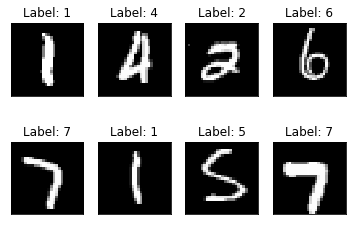

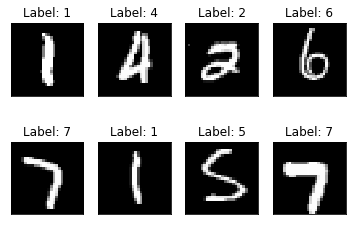

In [10]:
fig = plt.figure()
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(example[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])
fig

¡Ya casi hemos terminado! Ahora solo tenemos que instanciar el modelo, y decirle que optimizador vamos a utilizar, en este caso, descenso por el gradiente estocástico.

In [11]:
model = LogisticRegression().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

Y finalmente, un sencillo bucle sobre el número de épocas. Esto debería llevar unos pocos minutos en la cpu de un portátil...

In [12]:
train_losses = []
for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, train_losses)
        test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.443536
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.449057
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.255912
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.409034
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.241878
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.310971
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.225411
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.468771
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.483764
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.490922
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.191463
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.257455
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.167807
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.281548
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.354214
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.355108
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.296116
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.271146
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.406076

Test set: Average loss: 0.2934, Accuracy: 9180/10000 (92%)

**Ejercicio**: visualiza la función de pérdida a lo largo del entrenamiento:

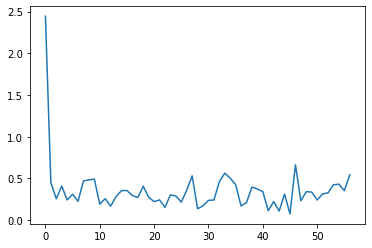

In [14]:
plt.plot(train_losses)

Como primer intento, hemos obtenido cerca del 92% de tasa de acierto, lo que no está mal, pero pronto veremos cómo mejorar los resultados

### Perceptrón multicapa para el MNIST

Ahora repetiremos lo anterior con una red neuronal más profunda


Como antes, definimos la estructura de la red. Usaremos una capa oculta con 50 neuronas y activación ReLu, pero sentíos libres para cambiarlo!

In [15]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

Ahora inicializaremos la red y elegiremos el optimizador. Proponemos utilizar SGD. Ponemos la learning_rate a 0.01 y el momentum a 0.5

In [16]:
learning_rate = 0.01
momentum = 0.5
model = MLP().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

Ahora entrenemos el modelo otra vez durante 3 épocas. 

In [17]:
training_losses = []
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, training_losses)
    test(model, device, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.360671
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.021303
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.386629
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.633212
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.270669
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.411773
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.489418
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.179881
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.258762
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.225675
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.161961
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.190058
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.396041
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.288078
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.365777
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.303023
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.210557
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.256768
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.259765

Test set: Average loss: 0.2112, Accuracy: 9386/10000 (94%)

¡Hemos alcanzado un 96% de tasa de acierto sobre el conjunto de evaluación!

## Introducción a redes convolucionales.

Este tipo de redes sustituyen las capas lineales por capas donde se hace una convolución. Sigue siendo una operación lineal, pero ahora los pesos se comparten entre las distintas features/píxeles.

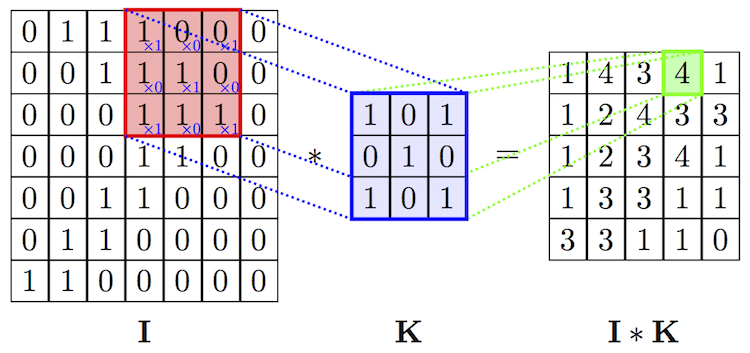

**Ejercicio** Introducción a redes convolucionales. Completa el paso forward del siguiente modelo que utiliza dos capas convolucionales previamente:

* Como activación no lineal utilza F.relu
* Después de las capas convolucionales utiliza F.max_pool2d para hacer pooling.
* Al pasar de las capas convolucionales a las lineas tendrás que aplanar a un vector como antes, o usando torch.flatten(x, 1)

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=(3,3))

        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


¿Cuál es la tasa de acierto del modelo ahora?

In [37]:
learning_rate = 0.01
momentum = 0.5
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [38]:
training_losses = []
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, training_losses)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291299
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.538866
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.258745
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.100316
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.339786
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.295962
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.167145
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.039560
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.071081
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.112411
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.159042
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.197125
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.036318
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.101389
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.090080
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.131015
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.018389
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.027199
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.126061

Test set: Average loss: 0.1086, Accuracy: 9657/10000 (97%)